In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from scipy.stats import *
from scipy.signal import *
import datetime
from scipy import *
from shapely.geometry import Polygon
import geopandas as gpd
import xarray as xr
from windrose import WindroseAxes
import os
import glob

In [2]:
solve_wind = True
solve_wave = True

inp_wind = glob.glob('F:/TUDELFT/Thesis/Thesis_GIT/Thesis/Windspeed/*.nc')
inp_wave = glob.glob('F:/TUDELFT/Thesis/Thesis_GIT/Thesis/ECHOWAVE/*.csv')

TS_start = 1991
TS_end = 2021

# Wind Power Calculation 

In [3]:
# Load all files as a list of datasets
datasets = [xr.open_dataset(file) for file in inp_wind]

# Combine the datasets into one dataset
combined = xr.concat(datasets, dim='time')

# List of variables to convert to DataFrame
variables = ['u100', 'v100']

# Convert each variable to DataFrame and store in a dictionary
dataframes = {var: combined[var].to_dataframe().reset_index() for var in variables}

# Extract individual DataFrames
df_wind_u100 = dataframes['u100']
df_wind_v100 = dataframes['v100']

# Calculate the total wind speed
df_wind_u100.set_index('time', inplace=True)
df_wind_v100.set_index('time', inplace=True)

total_windspeed = np.hypot(df_wind_u100['u100'], df_wind_v100['v100'])

# Create a new DataFrame with the time index and the calculated windspeed
df_wind = pd.DataFrame({
    'time': df_wind_u100.index,
    'windspeed': total_windspeed
})

df_wind_total = np.hypot(df_wind_u100['u100'], df_wind_v100['v100'])
df_wind_total = pd.DataFrame({'windspeed': df_wind_total})

df_wind.head()
single_speed = df_wind.iloc[0]['windspeed']

In [4]:
# Calculate wind speed at the hub
zh = 138
z_0 = 0.0002
z_ref = 100

df_u100_hub = df_wind_u100.copy()
df_v100_hub = df_wind_v100.copy()
df_wind_hub = df_wind_total.copy()
df_u100_hub['u100'] = df_wind_u100['u100'] * np.log(zh / z_0) / np.log(z_ref / z_0)
df_v100_hub['v100'] = df_wind_v100['v100'] * np.log(zh / z_0) / np.log(z_ref / z_0)
df_wind_hub['windspeed'] = df_wind_total['windspeed'] * np.log(zh / z_0) / np.log(z_ref / z_0)

Weibull parameters: shape=1.945, loc=0.000, scale=8.967


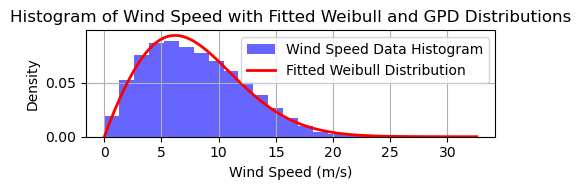

In [5]:
# Wind Generation Distribution
# Convert the index to datetime if not already
df_wind_total.index = pd.to_datetime(df_wind_total.index)

# Extract the windspeed data
windspeed_data = df_wind_hub['windspeed']
windspeed_data_clean = windspeed_data[np.isfinite(windspeed_data)]

# Fit a Weibull distribution to the data
params_weibull = weibull_min.fit(windspeed_data_clean, floc=0)
shape_weibull, loc_weibull, scale_weibull = params_weibull
print(f'Weibull parameters: shape={shape_weibull:.3f}, loc={loc_weibull:.3f}, scale={scale_weibull:.3f}')

# Generate x values for the Weibull PDF plot
x = np.linspace(windspeed_data.min(), windspeed_data.max(), 100)

# Calculate the PDF of the Weibull distribution
pdf_weibull = weibull_min.pdf(x, shape_weibull, loc_weibull, scale_weibull)

# Plot the histogram of the wind speed data and the fitted distributions
plt.figure(figsize=(5, 2))
plt.hist(windspeed_data, bins=25, density=True, alpha=0.6, color='b', label='Wind Speed Data Histogram')
plt.plot(x, pdf_weibull, 'r-', lw=2, label='Fitted Weibull Distribution')
# plt.plot(x, pdf_gpd, 'g-', lw=2, label='Fitted GPD Distribution')

# Add plot details
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Density')
plt.title('Histogram of Wind Speed with Fitted Weibull and GPD Distributions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

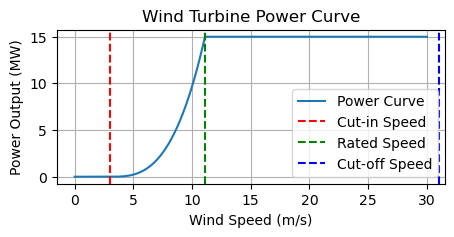

In [6]:
#Creating Power Curve

cutin_speed = 3 #m/s
r_speed = 11.1 #m/s
cutoff_speed = 31 #m/s
rated_power = 15 #MW 

wind_speed = np.linspace(0, 30, 500)
power_output_greedy = np.zeros_like(wind_speed)

for i, v in enumerate(wind_speed):
    if v < cutin_speed:
        power_output_greedy[i] = 0
    elif cutin_speed <= v < r_speed:
        power_output_greedy[i] = rated_power * ((v - cutin_speed) / (r_speed - cutin_speed)) ** 3
    elif r_speed <= v <= cutoff_speed:
        power_output_greedy[i] = rated_power
    else:
        power_output_greedy[i] = 0
        
plt.figure(figsize=(5,2))
plt.plot(wind_speed, power_output_greedy, label='Power Curve')
plt.axvline(cutin_speed, color='r', linestyle='--', label='Cut-in Speed')
plt.axvline(r_speed, color='g', linestyle='--', label='Rated Speed')
plt.axvline(cutoff_speed, color='b', linestyle='--', label='Cut-off Speed')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power Output (MW)')
plt.title('Wind Turbine Power Curve')
plt.legend()
plt.grid(True)
plt.savefig('./power_curve.png')
plt.show()

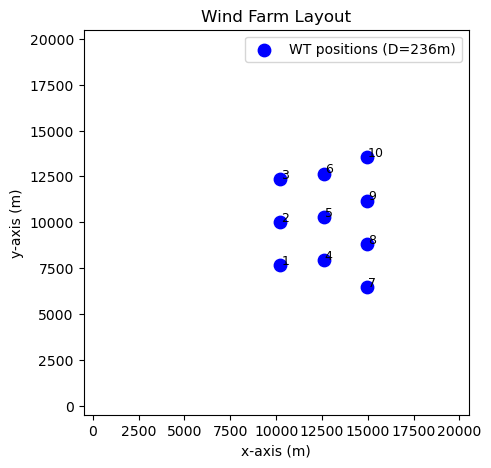

Total turbines placed: 10


In [11]:
# Wind farm area
farm_length = 20000  # x-axis (m)
farm_width = 20000   # y-axis (m)

# Rotor diameter
d0 = 236  # [m]
min_spacing_x = 10 * d0
min_spacing_y = 10 * d0

# Desired layout: 
layout_cols = [3, 3, 4]
n_turbines = sum(layout_cols)

# Generate turbine positions in zigzag pattern
turbines = []
row_spacing = min_spacing_y
col_spacing = min_spacing_x

start_x = d0 + 10000
start_y = farm_width / 2 - (len(layout_cols) - 1) * row_spacing / 2

for i, n_rows in enumerate(layout_cols):
    x = start_x + i * (col_spacing)
    total_height = (n_rows - 1) * row_spacing
    y_start = farm_width / 2 - total_height / 2
    for j in range(n_rows):
        y = y_start + j * row_spacing
        if i % 2 == 1:
            y += row_spacing / 8
        turbines.append((x, y))

turbines = np.array(turbines)

# Plot the layout
plt.figure(figsize=(5, 5))
plt.scatter(turbines[:, 0], turbines[:, 1], c='blue', label="WT positions (D=236m)", s=80)
for idx, (x, y) in enumerate(turbines):
    plt.text(x + 50, y + 50, str(idx + 1), fontsize=9, color='black')
plt.xlim(-500, farm_length + 500)
plt.ylim(-500, farm_width + 500)
plt.xlabel("x-axis (m)")
plt.ylabel("y-axis (m)")
plt.title("Wind Farm Layout")
plt.legend()
plt.gca().set_aspect('equal')
plt.show()

print(f"Total turbines placed: {len(turbines)}")

In [12]:
# Rated wind speed
rated_wind_speed = 11.1  # m/s
max_wind_hub = df_wind_hub['windspeed'].max

# Parameters
n_turbines = 10
d0 = 236
R = d0 / 2
rated_power = 15  # MW
Cp = 0.45
rho = 1.225
CT = 8/9
k_star = 0.04
b = 0.5 * (1 + np.sqrt(1 - CT)) / np.sqrt(1 - CT)
epsilon = 0.25 * np.sqrt(b)

# Rotor Grid
Ny, Nz = 15, 15
y_vals = np.linspace(-R, R, Ny)
z_vals = np.linspace(zh - R, zh + R, Nz)
dy = y_vals[1] - y_vals[0]
dz = z_vals[1] - z_vals[0]
Y, Z = np.meshgrid(y_vals, z_vals)
mask = np.pi * (Y**2 + (Z - zh)**2) <= np.pi * R**2

# Wake model functions
def sigma(x):
    return d0 * (k_star * (x / d0) + epsilon)

def C_deficit(x):
    sig = sigma(x)
    val = 1 - CT / (8 * (sig / d0)**2)
    return 1 - np.sqrt(val)

# Calculate power at 10.5 m/s wind
actual_powers = []
for i in range(n_turbines):
    xi, yi = turbines[i]
    U_rotor = rated_wind_speed * np.ones_like(Y)

    for j in range(n_turbines):
        if j == i:
            continue
        xj, yj = turbines[j]
        dx = xi - xj
        dy_rel = yi - yj
        if dx > 0:
            r_squared = (Y - dy_rel)**2 + (Z - zh)**2
            sig = sigma(dx)
            Cx = C_deficit(dx)
            U_wake = rated_wind_speed * (1 - Cx * np.exp(-0.5 * r_squared / (sig * d0)**2))
            U_rotor = np.minimum(U_rotor, U_wake)

    U_effective = U_rotor[mask]
    P_available = 0.5 * rho * np.sum(U_effective**3) * dy * dz
    P_actual = float(Cp * P_available / 1e6)
    P_actual = min(P_actual, rated_power)
    actual_powers.append(P_actual)

# Create result table
df_result = pd.DataFrame(turbines, columns=["X (m)", "Y (m)"])
df_result["Power (MW)"] = actual_powers

# Wave Energy 

In [13]:
inp_wave            = "OpenDAP"
solve_wave          = True

lat_target = 41.639164
lon_target = -9.142327

start_year          = 1991
end_year            = 2021

path_to_data_wave   = r'F:/TUDELFT/Thesis/Thesis_GIT/Thesis/ECHOWAVE/'

In [14]:
def process_wave(lat_target, lon_target, path_to_data_wave=None):
    dfs = []
    
    for file in glob.glob(os.path.join(path_to_data_wave, "*.csv")):
        df_wave = pd.read_csv(file)

        df_wave['Time'] = pd.to_datetime(df_wave['Time'])
        df_wave.set_index('Time', inplace=True)

        df = pd.DataFrame()
        df['Hs'] = df_wave['Hs']
        df['Tp'] = df_wave['Tp']
        dfs.append(df)

    df_wave_all = pd.concat(dfs).sort_index()
    return df_wave_all

In [15]:
def run_config(solve_wave, inp_wave):
    starttime = time.time()
    
    if lon_target > -8.7 and lon_target < -9.5:
        if lat_target > 42 and lat_target < 41:
            pass
        else:
            print('     latitude not solved in ResourceCode domain, please use different input')
            return
    else:
        print('     latitude not solved in ResourceCode domain, please use different input')
        return
    if solve_wave == True and inp_wave == "RC":
        print("     Wave is selected, input data is taken from ResourceCode")
    if solve_wave == True and inp_wave == "OpenDAP":
        print("     Wave is selected, input data is taken from OpenDAP")
    elif solve_wave == True and inp_wave == "other":
        print("     Wave is selected, input data is from other input file, please make sure it is loaded and compatible")
    elif solve_wave == False:
        print("     Wave is not selected")
    else:
        print("     Configuration not recognized, please check input file")
        
    endtime = time.time()
    print('         ...elapsed time:', round(endtime - starttime,2), 'seconds')

In [16]:
def get_resources_raw(solve_wave, inp_wave, start, end, lat_target=None, lon_target=None, path=None, path_wave=None):
    print('Running: get_resources_raw...')

    df = pd.DataFrame()
    
    if solve_wave == True and inp_wave == 'RC':
        if lat_target == None or lon_target == None or lat_target == None and lon_target == None:
            print("ResourceCode is selected, but no lat an/or lon is given as input")
        else:
            df['Hs'] = get_data_resourcecode(lat_target, lon_target, start, end)[0]
            df['Tp'] = get_data_resourcecode(lat_target, lon_target, start, end)[1]
    elif solve_wave == True and inp_wave == "OpenDAP":
        if path_wave == None:
            print("No path to OpenDAP data defined")
        else:
            print("warning: OpenDAP column name is now hard coded, not sure if all input files have the same column name")
            df_wave = process_wave(lat_target, lon_target, path_wave)
            df['Hs'] = df_wave['Hs']
            df['Tp'] = df_wave['Tp']
    elif solve_wave == True and inp_wave == "other":
        print("You will need to adjust this function to load the data of the wave resources")
    elif solve_wave == False:
        pass

    return df

In [17]:
resources_raw = get_resources_raw(
    solve_wave, 
    inp_wave, 
    start_year, 
    end_year, 
    lat_target, 
    lon_target, 
    None, 
    path_wave=path_to_data_wave
)

resources_raw.index = pd.date_range(start=f"{start_year}", periods=len(resources_raw), freq="H")

Running: get_resources_raw...


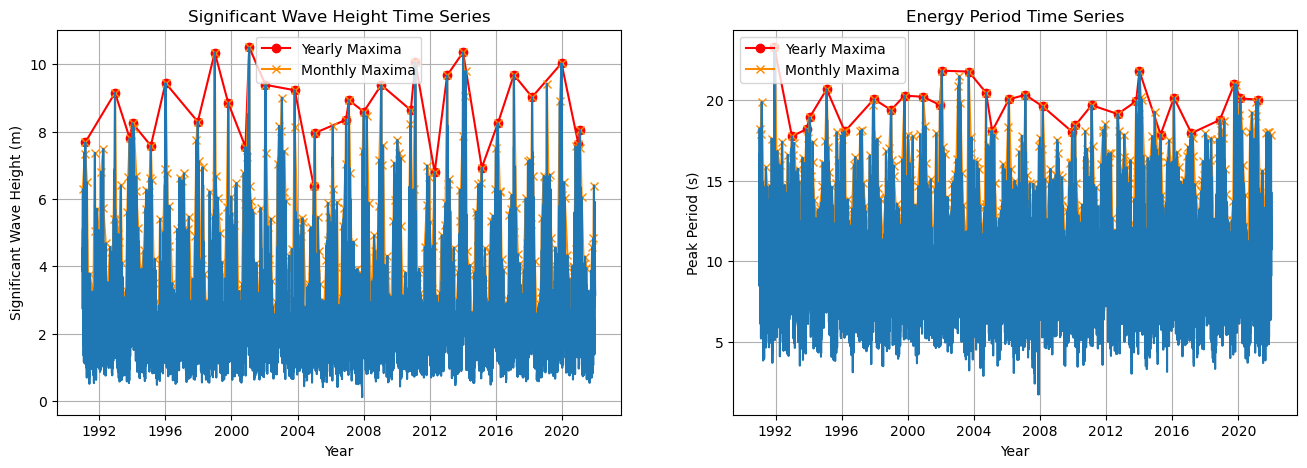

In [18]:
Hs_yearly_max_idx = resources_raw['Hs'].resample('Y').apply(lambda x: x.idxmax())
Hs_yearly_max = resources_raw['Hs'].resample('Y').max()

Hs_monthly_max_idx = resources_raw['Hs'].resample('M').apply(lambda x: x.idxmax())
Hs_monthly_max = resources_raw['Hs'].resample('M').max()

Te_yearly_max_idx = (resources_raw['Tp']*0.9).resample('Y').apply(lambda x: x.idxmax())
Te_yearly_max = (resources_raw['Tp']*0.9).resample('Y').max()

Te_monthly_max_idx = (resources_raw['Tp']*0.9).resample('M').apply(lambda x: x.idxmax())
Te_monthly_max = (resources_raw['Tp']*0.9).resample('M').max()
# Te = C * Tp, with C = 0.9 for JONSWAP spectrum standard (https://www.sciencedirect.com/science/article/abs/pii/S0029801821003723)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

ax1.plot(Hs_yearly_max_idx, Hs_yearly_max, marker='o', linestyle='-', label='Yearly Maxima', color='red')
ax1.plot(Hs_monthly_max_idx, Hs_monthly_max, marker='x', linestyle='-', label='Monthly Maxima', color='darkorange')
ax1.plot(resources_raw.index, resources_raw['Hs'].values)
ax1.set_title('Significant Wave Height Time Series')
ax1.set_xlabel('Year')
ax1.set_ylabel('Significant Wave Height (m)')
ax1.grid(True)
ax1.legend()

ax2.plot(Te_yearly_max_idx, Te_yearly_max, marker='o', linestyle='-', label='Yearly Maxima', color='red')
ax2.plot(Te_monthly_max_idx, Te_monthly_max, marker='x', linestyle='-', label='Monthly Maxima', color='darkorange')
ax2.plot(resources_raw.index, (resources_raw['Tp']*0.9).values)
ax2.set_title('Energy Period Time Series')
ax2.set_xlabel('Year')
ax2.set_ylabel('Peak Period (s)')
ax2.grid(True)
ax2.legend()

Significant Wave Height Weibull parameters: shape=2.075, loc=0.000, scale=2.650
Peak Period Weibull parameters: shape=4.910, loc=0.000, scale=11.860


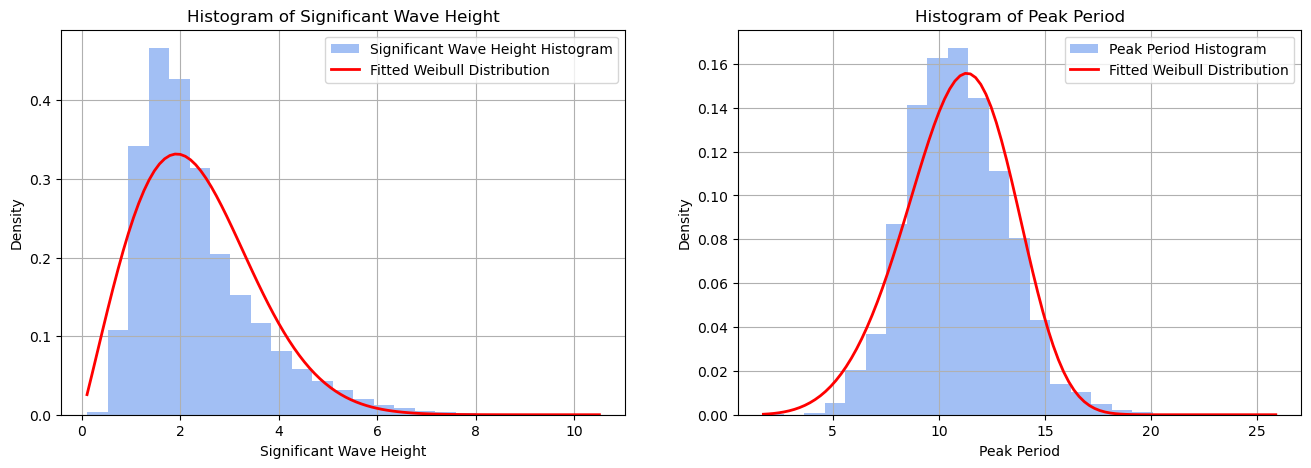

In [19]:
#Hs and Tp Histogram Plot 
Hs_data = resources_raw['Hs'].dropna()
Tp_data = resources_raw['Tp'].dropna()

params_weibull_Hs = weibull_min.fit(Hs_data, floc=0)
shape_weibull_Hs, loc_weibull_Hs, scale_weibull_Hs = params_weibull_Hs

params_weibull_Tp = weibull_min.fit(Tp_data, floc=0)
shape_weibull_Tp, loc_weibull_Tp, scale_weibull_Tp = params_weibull_Tp

x_Hs = np.linspace(Hs_data.min(), Hs_data.max(), 100)
x_Tp = np.linspace(Tp_data.min(), Tp_data.max(), 100)

pdf_weibull_Hs = weibull_min.pdf(x_Hs, shape_weibull_Hs, loc_weibull_Hs, scale_weibull_Hs)
pdf_weibull_Tp = weibull_min.pdf(x_Tp, shape_weibull_Tp, loc_weibull_Tp, scale_weibull_Tp)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

ax1.hist(Hs_data, bins=25, density=True, alpha=0.6, color='cornflowerblue', label='Significant Wave Height Histogram')
ax1.set_title('Histogram of Significant Wave Height')
ax1.plot(x_Hs, pdf_weibull_Hs, 'r-', lw=2, label='Fitted Weibull Distribution')
ax1.set_xlabel('Significant Wave Height')
ax1.set_ylabel('Density')
ax1.legend()
ax1.grid(True)

ax2.hist(Tp_data, bins=25, density=True, alpha=0.6, color='cornflowerblue', label='Peak Period Histogram')
ax2.set_title('Histogram of Peak Period')
ax2.plot(x_Tp, pdf_weibull_Tp, 'r-', lw=2, label='Fitted Weibull Distribution')
ax2.set_xlabel('Peak Period')
ax2.set_ylabel('Density')
ax2.legend()
ax2.grid(True)

print(f'Significant Wave Height Weibull parameters: shape={shape_weibull_Hs:.3f}, loc={loc_weibull_Hs:.3f}, scale={scale_weibull_Hs:.3f}')
print(f'Peak Period Weibull parameters: shape={shape_weibull_Tp:.3f}, loc={loc_weibull_Tp:.3f}, scale={scale_weibull_Tp:.3f}')

In [20]:
# Joint Probability Distribution using 2D Histogram
Hs = resources_raw['Hs'].dropna()
Tp = (resources_raw['Tp']*0.9).dropna()

# Ensure same length (drop unmatched NaNs)
data = pd.concat([Hs, Tp], axis=1).dropna()
Hs = data['Hs']
Tp = data['Tp']

# Define bins
hs_bins = np.linspace(Hs.min(), Hs.max(), 15)
tp_bins = np.linspace(Tp.min(), Tp.max(), 15)

# 2D histogram (joint occurrences)
hist, hs_edges, tp_edges = np.histogram2d(Hs, Tp, bins=[hs_bins, tp_bins], density=False)

# Convert to probability (%)
joint_prob = (hist / np.sum(hist)) * 100

In [21]:
def load_power_matrix(path):
    df_raw = pd.read_excel(path, header=None)
    tp_bins = pd.to_numeric(df_raw.iloc[4, 4:19].values, errors='coerce')
    hs_bins = pd.to_numeric(df_raw.iloc[6:15, 1].values, errors='coerce')
    power_values = df_raw.iloc[6:15, 4:19].values
    return pd.DataFrame(power_values, index=hs_bins, columns=tp_bins)

In [22]:
def compute_joint_probability_matrix(Hs, Tp, hs_bins, tp_bins):
    hist, hs_edges, tp_edges = np.histogram2d(Hs, Tp, bins=[hs_bins, tp_bins])
    joint_prob = hist / np.sum(hist)
    hs_centers = (hs_edges[:-1] + hs_edges[1:]) / 2
    tp_centers = (tp_edges[:-1] + tp_edges[1:]) / 2
    return pd.DataFrame(joint_prob, index=hs_centers, columns=tp_centers)

In [23]:
def compute_expected_power(power_matrix, prob_matrix):
    aligned = prob_matrix.reindex(index=power_matrix.index, columns=power_matrix.columns, method='nearest')
    return (power_matrix * aligned).sum().sum()

In [24]:
power_matrix_path = "F:/TUDELFT/Thesis/thesis_GIT/Thesis/Corpower.xlsx"
power_matrix = load_power_matrix(power_matrix_path)

np.random.seed(0)
Hs = resources_raw['Hs']
Tp = resources_raw['Tp'] * 0.9  #Te = 0.9Tp
data = pd.DataFrame({'Hs': Hs, 'Tp': Tp}).dropna()
Hs = data['Hs']
Tp = data['Tp']

In [25]:
#Determine binsbased on the PM
hs_bins = np.append(power_matrix.index.values, power_matrix.index.values[-1] + 0.5)
tp_bins = np.append(power_matrix.columns.values, power_matrix.columns.values[-1] + 1)

# Compute joint probability matrix
joint_prob_matrix = compute_joint_probability_matrix(Hs, Tp, hs_bins, tp_bins)

expected_power_kw = compute_expected_power(power_matrix, joint_prob_matrix)
print(f"Expected power output per device: {expected_power_kw:.2f} kW")

Expected power output per device: 241.96 kW


# Run Configuration

In [36]:
print(df_result.columns)
print(resources_raw.columns)

Index(['X (m)', 'Y (m)', 'Power (MW)'], dtype='object')
Index(['Hs', 'Tp'], dtype='object')


In [37]:
wave_series_kw = pd.Series(expected_power_kw, index=df_result.index)
wind_series_mw = df_result['Power (MW)']

# Scale to total MW
wave_total_mw = wave_series_kw  /1000
wind_total_mw = wind_series_mw

# Combine into single DataFrame
df_combined_output = pd.DataFrame({
    'wave': wave_total_mw,
    'wind': wind_total_mw
})

df_combined_output['total'] = df_combined_output['wave'] + df_combined_output['wind']
df_combined_output.index = df_combined_output['wind'].index

In [ ]:
def calc_shareGenerationPark(
    solve_wind=True, WT_device=0, nturb=10,
    solve_wave=True, wec_type=0, nwecs=75,
    wind_calc_setting="Old"
):
    # Units and placeholder globals
    global turbines, wecs, Power_unit, Factor_unit

    Power_unit = 'MW'
    Factor_unit = '-'

    # Define fallback dummy device specs
    if 'turbines' not in globals():
        turbines = {0: {'rated_output': 15}}  # default 15 MW
    if 'wecs' not in globals():
        wecs = {0: {'rated_output': 0.4}}     # default 0.4 MW

    # Initialize
    installed_wind = 0
    installed_wave = 0

    # Wind capacity
    if solve_wind:
        installed_wind = df_combined_output['wind'] *nturb 

    # Wave capacity
    if solve_wave:
        installed_wave = df_combined_output['wave'] *nwecs

    # Total and shares
    total_capacity = installed_wind + installed_wave
    OutputPark = {
        'Installed': {
            'total': total_capacity,
            'wind': installed_wind,
            'wave': installed_wave,
            'unit': Power_unit
        },
        'InstalledShare': {
            'total': 1.0,
            'wind': (installed_wind / total_capacity).round(2).fillna(0),
            'wave': (installed_wave / total_capacity).round(2).fillna(0),
            'unit': Factor_unit
        }
    }

    print(f"\nTotal installed capacity [{Power_unit}]: {total_capacity}")
    print(f" - Wind share: {OutputPark['InstalledShare']['wind']}")
    print(f" - Wave share: {OutputPark['InstalledShare']['wave']}")

    return OutputPark

In [39]:
OutputPark = calc_shareGenerationPark(
    solve_wind=True, WT_device=0, nturb=10,
    solve_wave=True, wec_type=0, nwecs=75,
    wind_calc_setting="Old"
)

total_sum = OutputPark['Installed']['total'].sum()
print(f"Total installed capacity over all time steps: {total_sum:.2f} MW")


Total installed capacity [MW]: 0    168.146638
1    168.146638
2    168.146638
3    133.278424
4    133.278424
5    133.278424
6    133.301971
7    133.286275
8    133.286275
9    133.286275
dtype: float64
 - Wind share: 0    0.89
1    0.89
2    0.89
3    0.86
4    0.86
5    0.86
6    0.86
7    0.86
8    0.86
9    0.86
dtype: float64
 - Wave share: 0    0.11
1    0.11
2    0.11
3    0.14
4    0.14
5    0.14
6    0.14
7    0.14
8    0.14
9    0.14
dtype: float64
Total installed capacity over all time steps: 1437.44 MW


In [40]:
AEP_MWh = total_sum * 8760 / 1000
print(f"Annual Energy Production of the Park: {AEP_MWh:.2f} MWh")

R_AEP = ((0.4 * 75) + (15 * 10)) * 8760 /100
print(f"Annual Rated Energy Production of the Park: {R_AEP:.2f} MWh")

CF = AEP_MWh / R_AEP
print(f"Capacity Factor of the Park: {CF:.2f}")


Annual Energy Production of the Park: 12591.94 MWh
Annual Rated Energy Production of the Park: 15768.00 MWh
Capacity Factor of the Park: 0.80


In [41]:
def calc_ParkOutput(df_output, OutputPark):
    cov = df_output.std() / df_output.mean()
    OutputPark['CoV'] = cov
    return cov

CoV = calc_ParkOutput(df_combined_output, OutputPark)
print("\nCoefficient of Variation (CoV):")
print(CoV)


Coefficient of Variation (CoV):
wave     0.000000
wind     0.134077
total    0.131543
dtype: float64
